In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

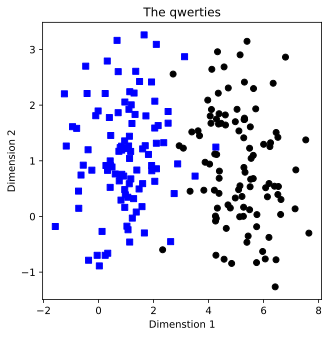

In [2]:
# create data

nPerCLuster = 100
blur = 1

A = [1,1]
B = [5,1]

a = [A[0]+ np.random.randn(nPerCLuster)*blur,A[1]+ np.random.randn(nPerCLuster)*blur]
b = [B[0]+ np.random.randn(nPerCLuster)*blur,B[1]+ np.random.randn(nPerCLuster)*blur]

# true label
labels_np = np.vstack((np.zeros((nPerCLuster,1)),np.ones((nPerCLuster,1))))
 # concatinate into a matrix
data_np = np.hstack((a,b)).T

# convert to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# plot the data
fig= plt.subplots(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties")
plt.xlabel("Dimenstion 1")
plt.ylabel("Dimension 2")
plt.show()

In [3]:
# build the model

ANNcls = nn.Sequential(
    nn.Linear(2,1),
    nn.ReLU(),
    nn.Linear(1,1),
    nn.Sigmoid(),
)

ANNcls

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)

In [4]:
# other model features

learningRate = 0.01

# loss function
lossFn = nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(ANNcls.parameters(), lr=learningRate)

In [6]:
# train the model
epochs = 1000
losses = torch.zeros(epochs)

for epochi in range(epochs):
    
    # forward pass
    y_hat = ANNcls(data)
    
    # compute loss
    loss = lossFn(y_hat,labels)
    losses[epochi] = loss.item()
    
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

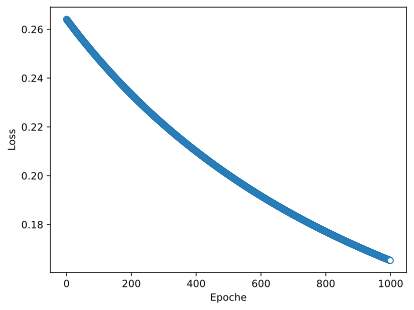

In [8]:
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=1)
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.show()


In [10]:
# compute the prediction

# manually compute losses
# final forward pass
prediction = ANNcls(data)

predLabels = prediction>.5

# find errors
misCls = np.where(predLabels != labels)[0]

# total acc
totalAcc = 100 - 100*len(misCls)/(2*nPerCLuster)

print("Final acc {}%".format(totalAcc))

Final acc 97.0%


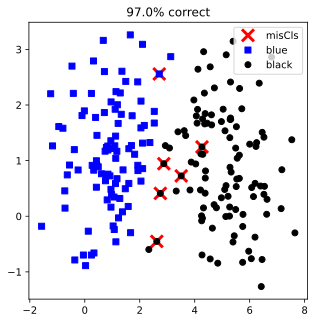

In [16]:
# plot the labeled data

fig = plt.figure(figsize=(5,5))
plt.plot(data[misCls,0],data[misCls,1],'rx',markersize=12,markeredgewidth=3)
plt.plot(data[np.where(~predLabels)[0],0],data[np.where(~predLabels)[0],1],'bs')
plt.plot(data[np.where(predLabels)[0],0],data[np.where(predLabels)[0],1],'ko')

plt.legend(['misCls','blue','black'])
plt.title(f"{totalAcc}% correct")
plt.show()